Keywords hold key standard in stating key representation of articles content.Most importantly keywords categorize an article into a relevant subject or discipline.

Traditionally, articles were given a tag, category based on readers judgment, which was very difficult, given huge corpus of text that is been generated now, which gets us to thinking what can be other way of getting this work done smartly and quickly and at same time, accurately tagging the relevant topics with meaningful entities.

# Dataset Used 

we will be using Neural Information Processing Systems (NIPS) is one of the top machine learning conferences in the world. This dataset includes the title and abstracts for all NIPS papers to date (ranging from the first 1987 conference to 2016 conference).
The dataset is available on kaggle here :- https://www.kaggle.com/benhamner/nips-papers/home

Work Involved in this experiment is as follows:-
    
    1] Data Loading
    2] Data Pre-Processing (cleaning data and noise removal)
    3] Data Exploration (Understanding the data)
    4] Convert data into Word-Vector Representation
    5] Based on word Frequencies Pick top words relevant to each topic

##### Step 1: Data Loading

In [2]:
import pandas as pd


import pandas
# load the dataset
dataset = pd.read_csv('papers.csv', delimiter = ',')
dataset.head()


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [3]:
dataset.shape

(7241, 7)

For experimentation, using entire paper text can be quite computationally heavy, so I decide to start with just abstract, so I select only those rows of dataframe where abstract is present and create a new column (data) by combining, Abstract + title.

In [13]:
df_abstract = dataset.loc[dataset['abstract']!='Abstract Missing']
df_abstract['data'] = df_abstract['title'] +'.' + df_abstract['abstract']
df_abstract.head()

C:\Users\sugat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,year,title,event_type,pdf_name,abstract,paper_text,data
941,1861,2000,Algorithms for Non-negative Matrix Factorization,NaN,1861-algorithms-for-non-negative-matrix-factor...,Non-negative matrix factorization (NMF) has pr...,Algorithms for Non-negative Matrix\nFactorizat...,Algorithms for Non-negative Matrix Factorizati...
1067,1975,2001,Characterizing Neural Gain Control using Spike...,NaN,1975-characterizing-neural-gain-control-using-...,Spike-triggered averaging techniques are effec...,Characterizing neural gain control using\nspik...,Characterizing Neural Gain Control using Spike...
2384,3163,2007,Competition Adds Complexity,NaN,3163-competition-adds-complexity.pdf,It is known that determinining whether a DEC-P...,Competition adds complexity\n\nJudy Goldsmith\...,Competition Adds Complexity.It is known that d...
2385,3164,2007,Efficient Principled Learning of Thin Junction...,NaN,3164-efficient-principled-learning-of-thin-jun...,We present the first truly polynomial algorith...,Efficient Principled Learning of Thin Junction...,Efficient Principled Learning of Thin Junction...
2388,3167,2007,Regularized Boost for Semi-Supervised Learning,NaN,3167-regularized-boost-for-semi-supervised-lea...,Semi-supervised inductive learning concerns ho...,Regularized Boost for Semi-Supervised Learning...,Regularized Boost for Semi-Supervised Learning...


In [14]:
df_abstract.shape

(3924, 8)

With 3924 samples, I think we got sufficiently large amount of data for computation.

##### Step 2: Data Exploration

Let us count total number of words in each SAMPLE

In [15]:
#Fetch wordcount for each abstract
df_abstract['word_count'] = df_abstract['data'].apply(lambda x: len(str(x).split(" ")))
df_abstract[['data','word_count']].head()

C:\Users\sugat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,data,word_count
941,Algorithms for Non-negative Matrix Factorizati...,111
1067,Characterizing Neural Gain Control using Spike...,87
2384,Competition Adds Complexity.It is known that d...,69
2385,Efficient Principled Learning of Thin Junction...,149
2388,Regularized Boost for Semi-Supervised Learning...,123


In [18]:
df_abstract['word_count'].describe()

count    3924.000000
mean      154.888124
std        46.001025
min        26.000000
25%       121.000000
50%       150.000000
75%       184.000000
max       324.000000
Name: word_count, dtype: float64

As we see above, the average word count in all samples is 154 words/doc, with minimum word count of 26 and max of 324.

It is time to clean up the data now, our preprocessing step will involve, two major steps:

            1] Noise Removal
            2] Normalization
            
For Noise Removal, we will be removing stop words which holds no meaning in deciding the meaning of the document.

In Normalization, we will be either using Stemming or Lemmatization to convert all words in root format, to maintain a consistency.

In [22]:
# Libraries for text preprocessing
import re
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

A. Noise Cancellation

In [23]:
df_abstract['data'] = df_abstract['data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

C:\Users\sugat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


B. Normalization Using Lemmatisation

In [25]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

df_abstract['data'] = df_abstract['data'].apply(lambda x: ' '.join([wordnet_lemmatizer.lemmatize(word) for word in x.split()]))

C:\Users\sugat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


The improvement in dataset can be checked by taking new word_count for newly updated columns

In [26]:
df_abstract['word_count'] = df_abstract['data'].apply(lambda x: len(str(x).split(" ")))
df_abstract[['data','word_count']].head()

C:\Users\sugat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,data,word_count
941,Algorithms Non-negative Matrix Factorization.N...,71
1067,Characterizing Neural Gain Control using Spike...,60
2384,Competition Adds Complexity.It known determini...,43
2385,Efficient Principled Learning Thin Junction Tr...,96
2388,Regularized Boost Semi-Supervised Learning.Sem...,84


Final Step of data exploration will involve data Visualization, which can be seen in word cloud created below

In [30]:
df_abstract.loc[941,'data']

'Algorithms Non-negative Matrix Factorization.Non-negative matrix factorization (NMF) previously shown useful decomposition multivariate data. Two different multi- plicative algorithm NMF analyzed. They differ slightly multiplicative factor used update rules. One algorithm shown minimize conventional least square error minimizes generalized Kullback-Leibler divergence. The monotonic convergence algorithm proven using auxiliary func- tion analogous used proving convergence Expectation- Maximization algorithm. The algorithm also interpreted diag- onally rescaled gradient descent, rescaling factor optimally chosen ensure convergence.'

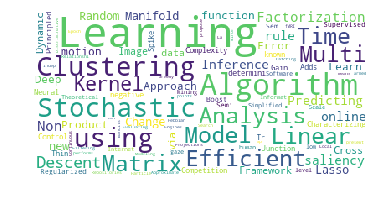

In [34]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(df_abstract['data']))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=1000)

Text data requires special preparation before you can start using it for predictive modeling.

Hence the text available here, needs to be converted into a format that can be used my ML algorithms and this can be done in 2 steps:
        
        1] Tokenization
        
        2] Vectorization
        
Tokenisation is the process of converting the continuous text into a list of words.

The list of words is then converted to a matrix of integers by the process of vectorisation. Vectorisation is also called feature extraction.

For this we will be using BAG OF WORDS model, which ignores the sequence of words but considers the frequency of words.

The text must be parsed to remove words, called tokenization. Then the words need to be encoded as integers or floating point values for use as input to a machine learning algorithm, called feature extraction (or vectorization).

The scikit-learn library offers easy-to-use tools to perform both tokenization and feature extraction of your text data.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(df_abstract['data'])

cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))

max_df — When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold 

(corpus-specific stop words). This is to ensure that we only have words relevant to the context and not commonly used words.

max_features — determines the number of columns in the matrix.

n-gram range — we would want to look at a list of single words, two words (bi-grams) and three words (tri-gram) combinations.

##### Let us Visulaize Top WORDS

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
  (0, 685)	5
  (0, 689)	1
  (0, 742)	1
  (0, 797)	1
  (0, 815)	1
  (0, 1262)	1
  (0, 2226)	1
  (0, 2901)	1
  (0, 2906)	3
  (0, 3266)	1
  (0, 3371)	1
  (0, 3553)	1
  (0, 3653)	1
  (0, 3691)	1
  (0, 3694)	1
  (0, 3912)	1
  (0, 4447)	1
  (0, 4548)	1
  (0, 4722)	1
  (0, 4878)	2
  (0, 4886)	2
  (0, 5321)	1
  (0, 5445)	1
  (0, 5619)	1
  (0, 6729)	1
  :	:
  (3923, 10163)	1
  (3923, 10191)	1
  (3923, 10639)	1
  (3923, 10661)	1
  (3923, 10741)	1
  (3923, 11340)	1
  (3923, 11446)	1
  (3923, 11688)	1
  (3923, 11792)	1
  (3923, 11883)	1
  (3923, 12309)	1
  (3923, 12326)	2
  (3923, 12338)	1
  (3923, 12432)	2
  (3923, 12564)	2
  (3

[Text(0,0,'we'),
 Text(0,0,'model'),
 Text(0,0,'learning'),
 Text(0,0,'algorithm'),
 Text(0,0,'data'),
 Text(0,0,'the'),
 Text(0,0,'method'),
 Text(0,0,'problem'),
 Text(0,0,'in'),
 Text(0,0,'show'),
 Text(0,0,'based'),
 Text(0,0,'approach'),
 Text(0,0,'function'),
 Text(0,0,'using'),
 Text(0,0,'network'),
 Text(0,0,'result'),
 Text(0,0,'time'),
 Text(0,0,'paper'),
 Text(0,0,'propose'),
 Text(0,0,'our')]

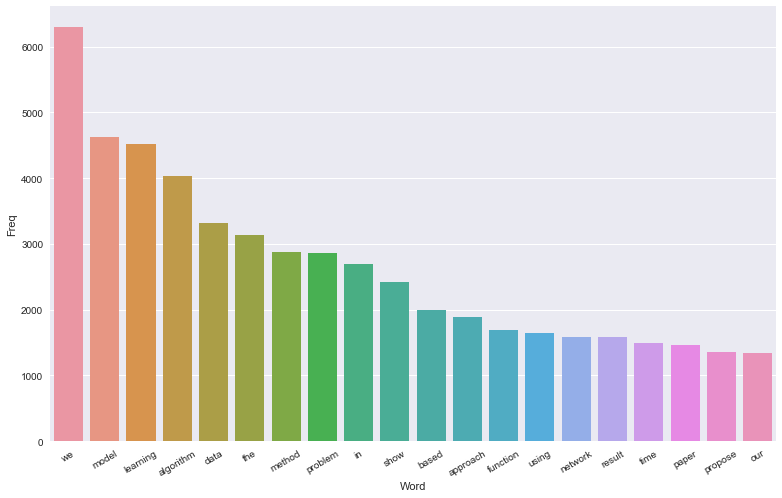

In [54]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    #print(vec)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(df_abstract['data'], n=20)
top_df = pandas.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)


                   Bi-gram  Freq
0                 in paper   967
1                  we show   734
2               we propose   607
3                 state of   582
4                   of the   574
5                  the art   564
6               we present   464
7           neural network   456
8         machine learning   428
9                  we also   396
10              real world   380
11        high dimensional   375
12          we demonstrate   341
13              this paper   308
14             we consider   304
15             large scale   302
16      learning algorithm   298
17  reinforcement learning   276
18           in particular   250
19                low rank   238


[Text(0,0,'in paper'),
 Text(0,0,'we show'),
 Text(0,0,'we propose'),
 Text(0,0,'state of'),
 Text(0,0,'of the'),
 Text(0,0,'the art'),
 Text(0,0,'we present'),
 Text(0,0,'neural network'),
 Text(0,0,'machine learning'),
 Text(0,0,'we also'),
 Text(0,0,'real world'),
 Text(0,0,'high dimensional'),
 Text(0,0,'we demonstrate'),
 Text(0,0,'this paper'),
 Text(0,0,'we consider'),
 Text(0,0,'large scale'),
 Text(0,0,'learning algorithm'),
 Text(0,0,'reinforcement learning'),
 Text(0,0,'in particular'),
 Text(0,0,'low rank')]

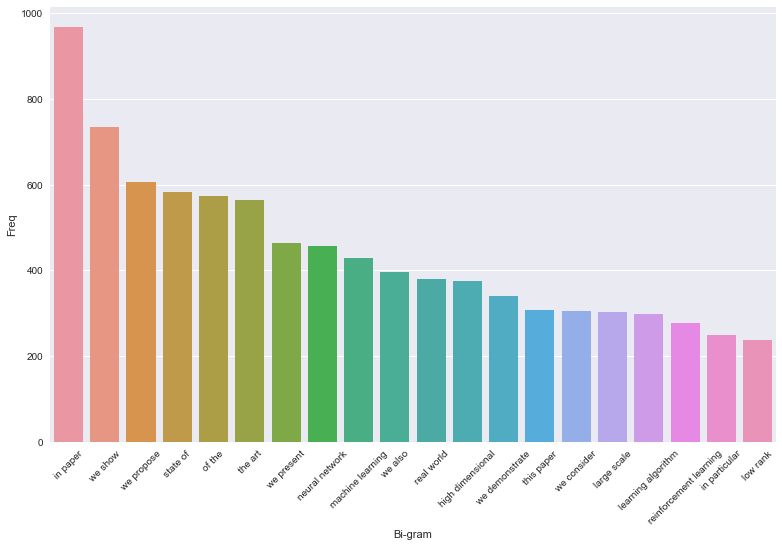

In [40]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(df_abstract['data'], n=20)
top2_df = pandas.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                        Tri-gram  Freq
0                   state of the   570
1                     of the art   563
2               in paper propose   231
3            we consider problem   111
4    stochastic gradient descent    95
5               in paper present    95
6   convolutional neural network    82
7       semi supervised learning    77
8            real world datasets    76
9                     end to end    74
10                we propose new    73
11              we propose novel    73
12               low rank matrix    71
13           the art performance    69
14               real world data    68
15                  we also show    66
16            in paper introduce    65
17            multi armed bandit    63
18           deep neural network    63
19          synthetic real world    62


[Text(0,0,'state of the'),
 Text(0,0,'of the art'),
 Text(0,0,'in paper propose'),
 Text(0,0,'we consider problem'),
 Text(0,0,'stochastic gradient descent'),
 Text(0,0,'in paper present'),
 Text(0,0,'convolutional neural network'),
 Text(0,0,'semi supervised learning'),
 Text(0,0,'real world datasets'),
 Text(0,0,'end to end'),
 Text(0,0,'we propose new'),
 Text(0,0,'we propose novel'),
 Text(0,0,'low rank matrix'),
 Text(0,0,'the art performance'),
 Text(0,0,'real world data'),
 Text(0,0,'we also show'),
 Text(0,0,'in paper introduce'),
 Text(0,0,'multi armed bandit'),
 Text(0,0,'deep neural network'),
 Text(0,0,'synthetic real world')]

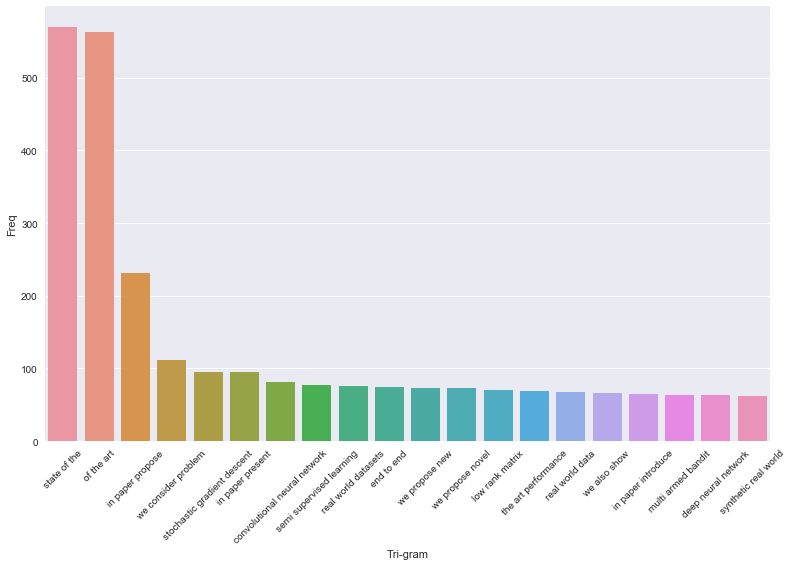

In [41]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(df_abstract['data'], n=20)
top3_df = pandas.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

As we observe words obtained from countVectoriser,large counts of certain common words may dilute the impact of more context specific words in the corpus. This is overcome by the TF-IDF vectoriser which penalizes words that appear several times across the document. TF-IDF are word frequency scores that highlight words that are more important to the context rather than those that appear frequently across documents.

In [42]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()

In [45]:
len(feature_names)

10000

In [55]:
# Let us select an document for which keywords needs to be extracted
doc=df_abstract.iloc[14]
doc = doc['data']
doc

'Evaluating Search Engines Modeling Relationship Between Relevance Clicks.We propose model leverage million click received web search engines, predict document relevance. This allows comparison ranking function click available complete relevance judgment not. After initial training phase using set relevance judgment paired click data, show model predict relevance score document judged. These prediction used evaluate performance search engine, using novel formalization confidence standard evaluation metric discounted cumulative gain (DCG), comparison made across time datasets. This contrast previous method provide pair-wise relevance judgement result shown query. When relevance judgment available, identify better two ranked list 82% time, two relevance judgment query, identify better ranking 94% time. While experiment sponsored search results, financial backbone web search, method general enough applicable algorithmic web search result well. Furthermore, give algorithm guide selection a

In [52]:
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))


Based on the TF-IDF scores, we can extract the words with the highest scores to get the keywords for a document.



In [53]:
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix

def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
for k in keywords:
    print(k,keywords[k])


Abstract:
Evaluating Search Engines Modeling Relationship Between Relevance Clicks.We propose model leverage million click received web search engines, predict document relevance. This allows comparison ranking function click available complete relevance judgment not. After initial training phase using set relevance judgment paired click data, show model predict relevance score document judged. These prediction used evaluate performance search engine, using novel formalization confidence standard evaluation metric discounted cumulative gain (DCG), comparison made across time datasets. This contrast previous method provide pair-wise relevance judgement result shown query. When relevance judgment available, identify better two ranked list 82% time, two relevance judgment query, identify better ranking 94% time. While experiment sponsored search results, financial backbone web search, method general enough applicable algorithmic web search result well. Furthermore, give algorithm guide s